# Exploring the __GAMA__ spectroscopic catalog
notebook by _Alex Malz (GCCL@RUB)_, _Kara Ponder (UC Berkeley)_, (add your name here)

In [99]:
from astropy.io import fits
import corner
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sncosmo
import urllib.request as ur

%matplotlib inline

We want to get the spectra of galaxies matching conditions found [here](http://www.gama-survey.org/dr3/schema/table.php?id=31).

In [2]:
with fits.open('SpecObj.fits') as hdul:
    hdul.info()
#     print(hdul[1].header)
    df = pd.DataFrame(np.array(hdul[1].data).byteswap().newbyteorder())
    print(df.columns)
    df.index = df['CATAID']

Filename: SpecObj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (3919,)   uint8   
  1  SpecObj       1 BinTableHDU    106   160026R x 19C   [J, 23A, I, I, I, E, 33A, 9A, I, D, D, E, D, E, I, E, 67A, 88A, 92A]   
Index(['CATAID', 'GAMA_NAME', 'IC_FLAG', 'N_SPEC', 'N_GAMA_SPEC', 'DIST',
       'SPECID', 'SURVEY', 'SURVEY_CODE', 'RA', 'DEC', 'WMIN', 'WMAX', 'Z',
       'NQ', 'PROB', 'FILENAME', 'URL', 'URL_IMG'],
      dtype='object')


## Galaxy redshifts

Each galaxy in the GAMA catalog has a spectroscopically confirmed redshift.  
We're going to match these redshifts to the snapshots of the particle data.

Text(0, 0.5, 'number of galaxies')

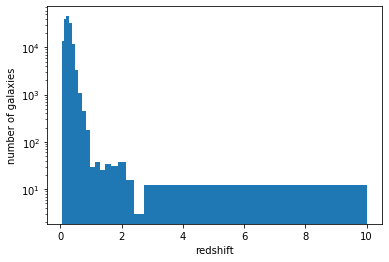

In [3]:
z_SLICS = np.array([0.042, 0.080, 0.130, 0.221, 0.317, 0.418, 0.525, 0.640, 0.764, 0.897, 
           1.041, 1.199, 1.372, 1.562, 1.772, 2.007, 2.269, 2.565, 2.899])
z_mids = (z_SLICS[1:] + z_SLICS[:-1]) / 2.
z_bins = np.insert(z_mids, 0, min(df['Z']))
z_bins = np.append(z_mids, max(df['Z']))
plt.hist(df['Z'], bins=z_bins)
plt.semilogy()
plt.xlabel('redshift')
plt.ylabel('number of galaxies')

The histogram of redshift is skewed by the use of `z=10` as a placeholder for not having a secure redshift.  
GAMA has a quality flag we can use to filter for redshifts that were considered of sufficient quality for science use, which they define as `NQ > 2`.

Text(0.5, 1.0, 'redshift distributions by quality flag "NQ"')

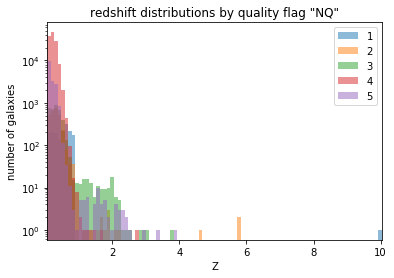

In [4]:
moar_bins = np.arange(z_bins[0], z_bins[-1] + z_bins[1], z_bins[1])
for i in range(5):
    quality = df.loc[df['NQ'] == i+1, 'Z']
    plt.hist(quality, alpha=0.5, label=str(i+1), bins=moar_bins)
plt.legend(loc='upper right')
plt.semilogy()
plt.xlim(moar_bins[0], moar_bins[-1])
plt.xlabel('Z')
plt.ylabel('number of galaxies')
plt.title('redshift distributions by quality flag "NQ"')

## Galaxy environment

GAMA observed galaxies in four disjoint regions of the sky.
Since environment is about the immediate vicinity of each galaxy, we'll have to divide the galaxies by region, effectively building our redshift-environment-color distribution separately for each region before combining those findings.

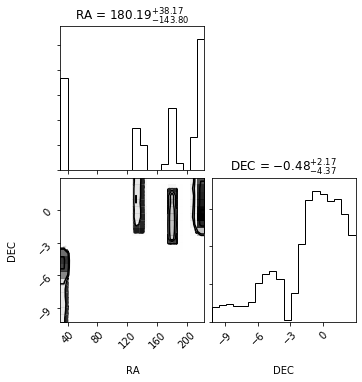

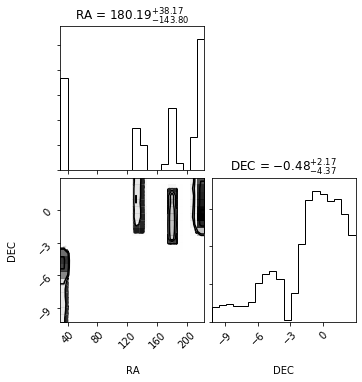

In [5]:
corner.corner(np.array([df['RA'], df['DEC']]).T, labels=['RA', 'DEC'], show_titles=True)

## How to select spectra by redshift and field

In [6]:
RA_bin_ends = [0., 80., 160., 200., 360.]
subsamples, lens = [], []
for i in range(len(RA_bin_ends)-1):
    subsamples.append(df.loc[(df['RA'] >= RA_bin_ends[i]) & (df['RA'] < RA_bin_ends[i+1]) 
                             & (df['NQ'] > 2), ['RA', 'DEC', 'Z', 'NQ', 'URL', 'FILENAME']])
    lens.append(len(subsamples[-1]))

In [7]:
subset = np.argmin(lens)
chosen_ind = subsamples[subset].sample(1, random_state=42).index[0]
# chosen_ind = subsamples[subset].sample(1).index[0]
subsamples[subset].URL[chosen_ind].decode('ascii')

'http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G09_Y1_IS1_370.fit       '

In [8]:
just_url = subsamples[subset].URL[chosen_ind].decode('ascii')
just_fn = subsamples[subset].FILENAME[chosen_ind].decode('ascii')[1:]
os.makedirs(os.path.dirname(just_fn), exist_ok=True)
spectrum = ur.urlretrieve(just_url, just_fn)

In [9]:
with fits.open(just_fn) as hdul:
    arr = np.array(hdul[0].data).byteswap().newbyteorder()
    metadata = hdul[0].header

## Download more spectra to explore

In [10]:
## Code to grab the spectra. It's a tad slow

#for i, url in enumerate(df['URL']):                # This will get all objects
for i, row in enumerate(zip(df['URL'].values[0:20], df['FILENAME'].values[0:20])): # This gets the first 20 objects
    url, fn = row
    u = url.decode('utf-8')
    f = '/'.join(fn.decode('utf-8')[1:].split('/')[:-1]) # drop preceding "/" and the file name
    try:
        cmd = 'wget ' + u + '-P ' + f
        os.system(cmd)
    except:
        print('no URL for this galaxy') ## I do expect at least 10 exceptions because 10 have 'xxx' for urls

GAMA includes the spectra of all galaxies in these fields, even if they were originally observed by another survey.
We're only looking at the "best" spectrum for each galaxy, and sometimes that spectrum came from another survey.

In [11]:
## Looking at some stats

gama_c = 0
gamaLT_c = 0
sdss_c = 0
dfgrs2_c = 0
qz_c = 0
slaq_lrg_c = 0
slaq_qso_c = 0
dfgs6_c = 0
mgc_c = 0
vvds_c = 0
wigglez_c = 0


for i, url in enumerate(df['URL']):
    u = url.decode('utf-8')
    if '/sdss/' in u:
        sdss_c += 1
    elif '/gama_LT/' in u:
        gamaLT_c += 1
    elif '/gama/' in u:
        gama_c += 1
    elif '/2dfgrs/' in u:
        dfgrs2_c += 1
    elif '/2qz/' in u:
        qz_c += 1
    elif '/2slaq-lrg/' in u:
        slaq_lrg_c += 1
    elif '/2slaq-qso/' in u:
        slaq_qso_c += 1
    elif '/6dfgs/' in u:
        dfgs6_c += 1
    elif '/mgc/' in u:
        mgc_c += 1
    elif '/vvds/' in u:
        vvds_c += 1 
    elif '/wigglez/' in u:
        wigglez_c += 1 
    else:
        print('URL='+str(u)) #, df.iloc[i])

print('\nsdss: ', sdss_c, '\nGAMA, LT: ', gama_c, gamaLT_c, '\n2dfgrs: ', dfgrs2_c, '\n2QZ: ', qz_c,
       '\nslaq_lrg_c', slaq_lrg_c, '\nslaq_qso_c: ', slaq_qso_c, '\ndfgs6_c', dfgs6_c, '\nmgc_c', mgc_c, 
      '\nvvds_c', vvds_c, '\nwigglez_c', wigglez_c)

URL=xxx                                                                                     
URL=xxx                                                                                     
URL=xxx                                                                                     
URL=xxx                                                                                     
URL=xxx                                                                                     
URL=xxx                                                                                     
URL=xxx                                                                                     
URL=xxx                                                                                     
URL=xxx                                                                                     
URL=xxx                                                                                     

sdss:  23228 
GAMA, LT:  133494 15 
2dfgrs:  2075 
2QZ:  157 
slaq_lr

## Play with some spectra!

Here are the surveys included in the data lists along with the number of spectra from each survey.

1. GAMA : 133494
2. SDSS : 23228 
3. VVDS (VIMOS VLT Deep Survey) : 66

None of these are flux calibrated so we probably can't use them:
4. GAMA_LT (GAMA Liverpool Telescope) : 15  
5. ^ 2dFGRS (The 2dF Galaxy Redshift Survey) : 2075  
6. ^ 2QZ (2dF QSO Redshift Survey) : 157 
7. 2SLAQ-LRG (2dF-SDSS LRG and QSO (2SLAQ) Luminous Red Galaxy Survey) : 27 
8. 2SLAQ-QSO (2dF-SDSS LRG and QSO (2SLAQ) Luminous Red Galaxy Survey) : 32
9. MGC (Millinium Galaxy Catalog) : 664 
10. WiggleZ : 87
11. 6dFGS (6dF Galaxy Survey) : 171 

### GAMA

These have 1 HDU with 5 rows where:
- ROW1    = 'Spectrum'           / Flux-calibrated spectrum in 10^-17 erg/s/cm^2/A
- ROW2    = 'Error   '           / 1 sigma error spectrum                         
- ROW3    = 'Spectrum_nocalib'   / Spectrum without flux calibration              
- ROW4    = 'Error_nocalib'      / 1 sigma error spectrum (no flux calibration)   
- ROW5    = 'Sky     '           / Sky spectrum (no flux calibration)   (Sky spectra are removed from the science spectrum during calibration)

This information can be found in the headers of the data. 

The flux is reported in units of 10^-17 erg/s/cm^2/A. 

The wavelength can be determined also based on header values. 
It can be described by a simple linear relationship:
- 'CD1_1' = slope
- 'WMIN' = intercept
    
    lambda = slope * x + intercept
    
   where x =  0,..N, where N is the total number of pixels and lambda is in Angstroms. 

In [12]:
## Open a file from GAMA 
# use only the first HDU that contains the spectrum 

f = df['FILENAME'].values[0].decode('utf-8')[1:].strip()
print(f)
gama_hdu = fits.open(f)
gama_fits = gama_hdu[0]

GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit


In [13]:
gama_hdu.info()

Filename: GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      72   (4953, 5)   float32   


In [14]:
gama_fits.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4953 / length of data axis 1                          
NAXIS2  =                    5 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BSCALE  =                   1. / True_value = BSCALE * FITS_value + BZERO       
BZERO   =                   0. / True_value = BSCALE * FITS_value + BZERO       
DATE    = '2015-03-24T13:43:56' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'GAMA    '           / Source of the data                             
OBSERVAT= 'SSO     '        

In [15]:
## Set the wavelengths of the spectra
# Make sure these match the WMIN and WMAX from the headers above

x_gama = np.arange(0, len(gama_fits.data[0]))
wv_gama = gama_fits.header['CD1_1']*x_gama + gama_fits.header['WMIN']

print(wv_gama[0], wv_gama[-1])

3727.71 8857.66996093628


Text(0, 0.5, 'Flux  [$10^{-17}$ erg/s/$cm^2/\\AA$]')

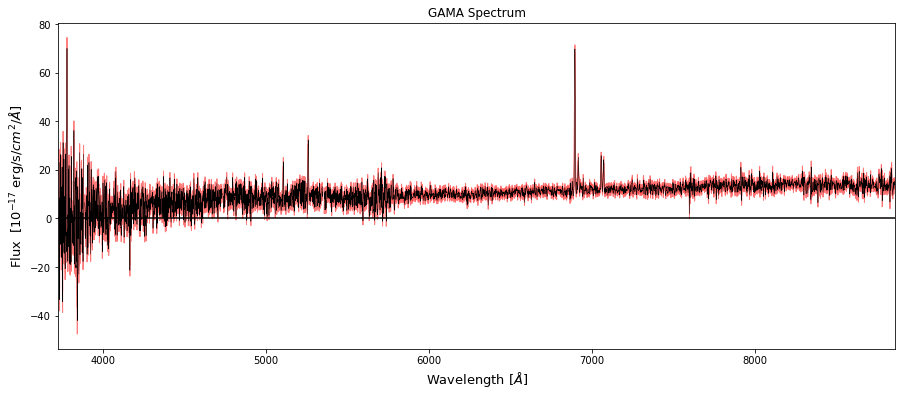

In [16]:
## Quick plot of the spectrum plus the variance. 
# Turn on the the other plotting functions to see what non-calibrated spectra look like. 

plt.figure(figsize=(15, 6))

# plt.plot(wv_gama, gama_fits.data[0], label='Spectrum')
# plt.plot(wv_gama, gama_fits.data[1], label=r'$1\sigma$ Error')
plt.plot(wv_gama, gama_fits.data[0], linewidth=0.5, color='k')
sigma = np.sqrt(gama_fits.data[1])
plt.fill_between(wv_gama, gama_fits.data[0] - sigma, gama_fits.data[0] + sigma, alpha=0.5, color='r')
#plt.plot(wv_gama, gama_fits.data[2], label='Non-calibrated Spectrum')
#plt.plot(wv_gama, gama_fits.data[3], label=r'$1\sigma$ Error on Non-calibrated Spectrum')
#plt.plot(wv_gama, gama_fits.data[4], label='Sky Spectrum') 

plt.axhline(0, color='k')

#plt.ylim(-10, 30)
plt.xlim(gama_fits.header['WMIN'], gama_fits.header['WMAX'])

plt.title('GAMA Spectrum')
plt.xlabel(r'Wavelength [$\AA$]', size=13)
plt.ylabel(r'Flux  [$10^{-17}$ erg/s/$cm^2/\AA$]', size=13)

### SDSS
These files have 3 fits extensions:
- Primary with 5 dimensions:
    1. ARRAY1  = 'SPECTRUM'           / 10^-17 erg/s/cm^2/A                            
    2. ARRAY2  = 'VARIANCE'                                                            
    3. ARRAY3  = 'SKY     '           / Subtracted sky spectrum                        
    4. ARRAY4  = 'MODEL   '           / Best fit used for classification and redshift  
    5. ARRAY5  = 'WDISP   '           / Wavelength dispersion             
- MASKS
- SPECOBJ
- SPZLINE

We only need the primary HDU. 

The flux is in the same units as in GAMA; however the wavelength is given in log10. 
- 'CDELT1': slope in log10
- 'CRVAL1': intercept in log10

    lambda = 10^(slope * x + intercept)
    
where x =  0,..N, where N is the total number of pixels and lambda is in Angstroms.   

In [17]:
f = df['FILENAME'].values[8].decode('utf-8')[1:].strip() 
print(f)

sdss_hdu = fits.open(f)
sdss_fits = sdss_hdu[0]

GAMA/dr3/data/spectra/sdss/spec-0282-51658-0538.fit


In [18]:
sdss_hdu.info()
df.iloc[8]

Filename: GAMA/dr3/data/spectra/sdss/spec-0282-51658-0538.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     167   (3841, 5)   float32   
  1  MASKS         1 BinTableHDU     13   3841R x 2C   [J, J]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


CATAID                                                      6826
GAMA_NAME                             b'GAMAJ113644.38+004232.5'
IC_FLAG                                                     4104
N_SPEC                                                         3
N_GAMA_SPEC                                                    0
DIST                                                        0.01
SPECID                      b'317651685860206592               '
SURVEY                                              b'SDSS     '
SURVEY_CODE                                                    1
RA                                                       174.185
DEC                                                      0.70906
WMIN                                                     3801.89
WMAX                                                      9204.5
Z                                                        0.07275
NQ                                                             5
PROB                     

In [19]:
sdss_fits.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3841 / length of data axis                            
NAXIS2  =                    5 / length of data axis                            
EXTEND  =                    T                                                  
TAI     =        4463270642.71 / 1st row - Number of seconds since Nov 17 1858  
SDSS_RA =            173.76976 / 1st row - Right ascension of telescope boresigh
SDSS_DEC=            -0.121563 / 1st row - Declination of telescope boresight (d
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '           /                                                
TAIHMS  = '04:08:50.90'        / 1st row - TAI time (HH:MM:SS.SS) (TAI-UT = appr
TIMESYS = 'tai     '        

In [20]:
x_sdss = np.arange(0, len(sdss_fits.data[0]))
wv_sdss_log = sdss_fits.header['CRVAL1'] + sdss_fits.header['CDELT1']* x_sdss
wv_sdss = 10**(wv_sdss_log)

print(wv_sdss[0], wv_sdss[-1])

3801.8939632056126 9204.495717531712


Text(0, 0.5, 'Flux  [$10^{-17}$ erg/s/$cm^2/\\AA$]')

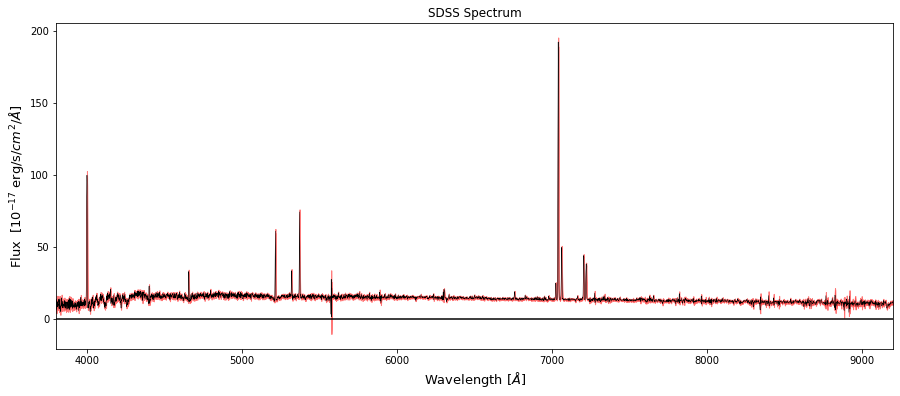

In [21]:
plt.figure(figsize=(15, 6))

# plt.plot(wv_sdss, sdss_fits.data[0], label='Spectrum')
# plt.plot(wv_sdss, sdss_fits.data[1], label='Variance')
plt.plot(wv_sdss, sdss_fits.data[0], color='k', linewidth=0.5)
sigma = np.sqrt(sdss_fits.data[1])
plt.fill_between(wv_sdss, sdss_fits.data[0] - sigma, sdss_fits.data[0] + sigma, alpha=0.5, color='r')
#plt.plot(wv_sdss, sdss_fits.data[2], label='Sky Spectrum')
#plt.plot(wv_sdss, sdss_fits.data[3], label='Best fit model')
#plt.plot(wv_sdss, sdss_fits.data[5], label='Wavelenght dispersion')

plt.axhline(0, color='k')

# plt.legend()

plt.xlim(sdss_fits.header['WMIN'], sdss_fits.header['WMAX'])

plt.title('SDSS Spectrum')
plt.xlabel(r'Wavelength [$\AA$]', size=13)
plt.ylabel(r'Flux  [$10^{-17}$ erg/s/$cm^2/\AA$]', size=13)

## VVDS
There is 1 HDU with 3 elements
- ROW1    = 'SPECTRUM'                                                            
- ROW2    = 'ERROR   '                                                            
- ROW3    = 'SKY     '   

These spectra ARE FLUX CALIBRATED, but they are not divided by 10^17 like the other 2. 
Linear wavelength, Converted the flux to be to be same units as GAMA and SDSS.

In [22]:
# look for a file to download
for i, s in enumerate(df['SURVEY']):
    survey = s.decode('utf-8')
    if 'VVDS' in survey:
        print(survey, i)
        break

VVDS      137087


In [23]:
# Note: you can view the object here http://www.gama-survey.org/dr3/tools/sov.php once you get its CATID
df.iloc[137087]

CATAID                                                   1780037
GAMA_NAME                             b'GAMAJ022614.58-044916.0'
IC_FLAG                                                     1024
N_SPEC                                                         1
N_GAMA_SPEC                                                    0
DIST                                                         0.2
SPECID                      b'VVDS020087675                    '
SURVEY                                              b'VVDS     '
SURVEY_CODE                                                   13
RA                                                       36.5608
DEC                                                     -4.82107
WMIN                                                     5514.28
WMAX                                                     9484.12
Z                                                         0.3826
NQ                                                             3
PROB                     

In [24]:
cmd = 'wget ' + df.iloc[137087]['URL'].decode('utf-8') + '-P ' \
       + '/'.join(df.iloc[137087]['FILENAME'].decode('utf-8')[1:].split('/')[:-1])

os.system(cmd)


0

In [25]:
f = df['FILENAME'].values[137087].decode('utf-8')[1:].strip() 
print(f)

vvds_hdu = fits.open(f)
vvds_fits = vvds_hdu[0]

GAMA/dr3/data/spectra/vvds/020087675_F02P017_vmM1_red_49_1.fit


In [26]:
vvds_hdu.info()

Filename: GAMA/dr3/data/spectra/vvds/020087675_F02P017_vmM1_red_49_1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     444   (557, 3)   float32   


In [27]:
vvds_fits.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  557 / Axis length                                    
NAXIS2  =                    3 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
IRAF-TLM= '2014-08-27T16:15:46' / Time of last modification                     
OBJECT  = 'F02P017 '           / Name of the object observed                    
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H   
ORIGIN  = 'ESO     '           / European Southern Observatory                  
DATE    = '2002-11-12T03:00:

In [28]:
x_vvds = np.arange(0, len(vvds_fits.data[0]))
wv_vvds = vvds_fits.header['CDELT1']*x_vvds + vvds_fits.header['WMIN']

print(wv_vvds[0], wv_vvds[-1])

5514.28 9484.119925765994


Text(0, 0.5, 'Flux  [$10^{-17}$ erg/s/$cm^2/\\AA$]')

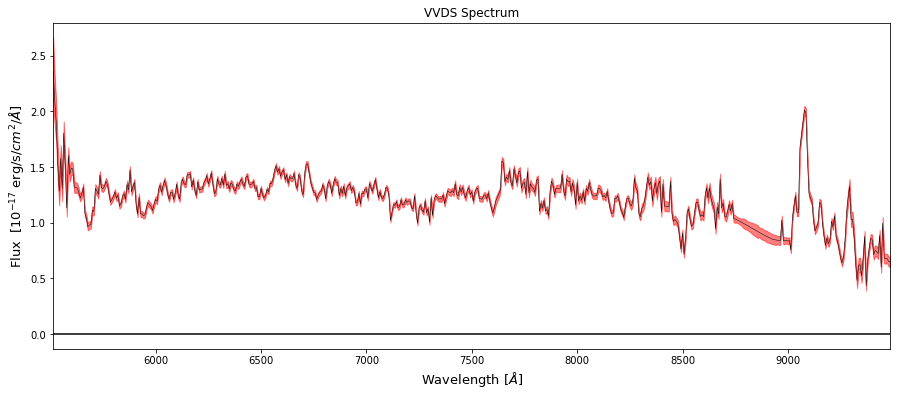

In [29]:
plt.figure(figsize=(15, 6))

# plt.plot(wv_vvds, vvds_fits.data[0]/1e-17, label='Spectrum')
# plt.plot(wv_vvds, vvds_fits.data[1]/1e-17, label='Error')
sigma = vvds_fits.data[1]/1e-17
plt.plot(wv_vvds, vvds_fits.data[0]/1e-17, color='k', linewidth=0.5)
plt.fill_between(wv_vvds, vvds_fits.data[0]/1e-17 - sigma, vvds_fits.data[0]/1e-17 + sigma, alpha=0.5, color='r')
#plt.plot(wv_sdss, sdss_fits.data[2], label='Sky Spectrum')

plt.axhline(0, color='k')

# plt.legend()

plt.xlim(vvds_fits.header['WMIN'], vvds_fits.header['WMAX'])

plt.title('VVDS Spectrum')
plt.xlabel(r'Wavelength [$\AA$]', size=13)
plt.ylabel(r'Flux  [$10^{-17}$ erg/s/$cm^2/\AA$]', size=13)

### 2dFGRS 

These have 1 HDU with 3 rows where:
- ROW1    = 'SPECTRUM'                                                            
- ROW2    = 'VARIANCE'                                                            
- ROW3    = 'SKY     '    

Wavelength is the normal linear solution.

The spectrum is given in arbitrary flux units. *The 2dFGRS spectra are not flux-calibrated.*

Some of these objects have photometry from SDSS though. 
Because these are not flux calibrated, we cannot use them, but I include it here as an example.

In [30]:
# I did not download a 2dFGRS spectrum in the first 20 entries, so I need to find one to download
for i, s in enumerate(df['SURVEY']):
    survey = s.decode('utf-8')
    if '2dFGRS' in survey:
        print(survey, i)
        break

2dFGRS    153


In [31]:
df.iloc[153]

CATAID                                                      7182
GAMA_NAME                             b'GAMAJ114420.48+004812.9'
IC_FLAG                                                     4104
N_SPEC                                                         1
N_GAMA_SPEC                                                    0
DIST                                                        0.46
SPECID                      b'2dF292397                        '
SURVEY                                              b'2dFGRS   '
SURVEY_CODE                                                    2
RA                                                       176.085
DEC                                                       0.8035
WMIN                                                     3612.17
WMAX                                                     8021.61
Z                                                        0.10618
NQ                                                             4
PROB                     

In [32]:
cmd = 'wget ' + df.iloc[153]['URL'].decode('utf-8') + '-P ' \
       + '/'.join(df.iloc[153]['FILENAME'].decode('utf-8')[1:].split('/')[:-1])

    
os.system(cmd)

0

In [33]:
f = df['FILENAME'].values[153].decode('utf-8')[1:].strip()
print(f)

dfgrs2_hdu = fits.open(f)
dfgrs2_fits = dfgrs2_hdu[0]

GAMA/dr3/data/spectra/2dfgrs/292397.fit


In [34]:
dfgrs2_hdu.info()

Filename: GAMA/dr3/data/spectra/2dfgrs/292397.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPECTRUM      1 PrimaryHDU     157   (1024, 3)   float32   


In [35]:
dfgrs2_fits.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                    3 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRVAL1  =         5814.7304688 / Co-ordinate value of axis 1                    
CDELT1  =         4.3103027344 / Co-ordinate increment along axis 1             
CRPIX1  =       512.0000000000 / Reference pixel along axis 1                   
CUNIT1  = 'Angstroms'          / Units for axis 1                               
EXTNAME = 'SPECTRUM'        

In [36]:
x_dfgrs2 = np.arange(0, len(dfgrs2_fits.data[0]))
wv_dfgrs2 = dfgrs2_fits.header['CDELT1']*x_dfgrs2 + dfgrs2_fits.header['WMIN']

print(wv_dfgrs2[0], wv_dfgrs2[-1])

3612.17 8021.6096972912


Text(0, 0.5, 'Flux [Arbitrary Units]')

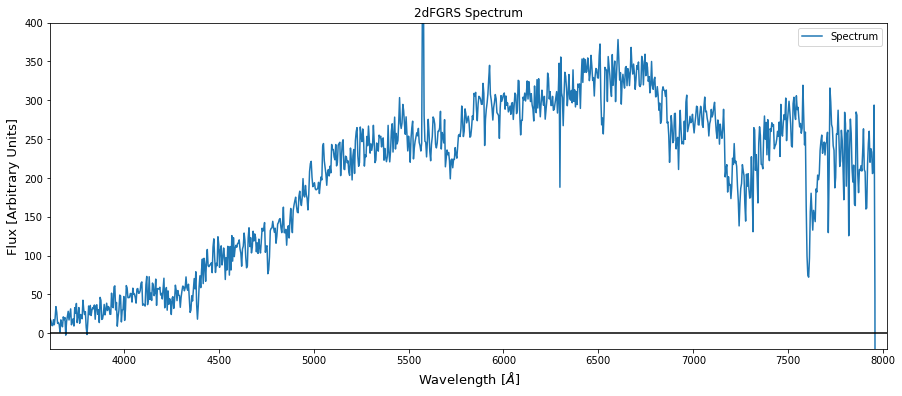

In [37]:
plt.figure(figsize=(15, 6))

plt.plot(wv_dfgrs2, dfgrs2_fits.data[0], label='Spectrum')
#plt.plot(wv_dfgrs2, dfgrs2_fits.data[1], label='Variance')
#plt.plot(wv_dfgrs2, dfgrs2_fits.data[2], label='Sky Spectrum')


plt.axhline(0, color='k')

plt.legend()

plt.xlim(dfgrs2_fits.header['WMIN'], dfgrs2_fits.header['WMAX'])
plt.ylim(-20, 400)

plt.title('2dFGRS Spectrum')
plt.xlabel(r'Wavelength [$\AA$]', size=13)
plt.ylabel('Flux [Arbitrary Units]', size=13)

### 2QZ

Three HDUs
- Primary (spectrum)
- Bad pixel masks
- Variance 

Normal linear wavelenght solution.

Spectra are not given in flux units and so can be converted via BZERO and BSCALE headers
    True_value = BSCALE * FITS_value + BZERO 
   
Because these are not flux calibrated, we cannot use them, but I include it here as an example.

In [38]:
for i, s in enumerate(df['SURVEY']):
    survey = s.decode('utf-8')
    if '2QZ' in survey:
        print(survey, i)
        break

2QZ       16825


In [39]:
df.iloc[16825]

CATAID                                                     77982
GAMA_NAME                             b'GAMAJ142230.77+000302.4'
IC_FLAG                                                     4104
N_SPEC                                                         2
N_GAMA_SPEC                                                    1
DIST                                                        0.42
SPECID                      b'2QZJ142230.7+000302a             '
SURVEY                                              b'2QZ      '
SURVEY_CODE                                                    8
RA                                                       215.628
DEC                                                      0.05059
WMIN                                                     3635.19
WMAX                                                     8044.87
Z                                                         0.3838
NQ                                                             3
PROB                     

In [40]:
cmd = 'wget ' + df.iloc[16825]['URL'].decode('utf-8') + '-P ' \
       + '/'.join(df.iloc[16825]['FILENAME'].decode('utf-8')[1:].split('/')[:-1])

os.system(cmd)

0

In [41]:
## Open these the same as the others.
# However, the variance is split into a different HDU instead of being another array in the Primary HDU

f = df['FILENAME'].values[16825].decode('utf-8')[1:].strip()
print(f)

qz_hdu = fits.open(f)
qz_fits = qz_hdu[0]
qz_var = qz_hdu[2]   ## variance HDU

GAMA/dr3/data/spectra/2qz/J142230.7+000302a.fit


In [42]:
qz_hdu.info()

Filename: GAMA/dr3/data/spectra/2qz/J142230.7+000302a.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (1024,)   int16 (rescales to float32)   
  1  BADPIX        1 ImageHDU        15   (1024,)   uint8   
  2  VARIANCE      1 ImageHDU        17   (1024,)   int16 (rescales to float32)   


In [43]:
qz_fits.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    1 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
BLANK   =               -32768 / Value for null pixels                          
BZERO   =   1.501753082275E+02 / True_value = BSCALE * FITS_value + BZERO       
BSCALE  =   1.406759861857E-02 / True_value = BSCALE * FITS_value + BZERO       
RA_OBJ  =     3.7634207412E+

In [44]:
qz_var.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    1 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
BLANK   =               -32768 / Value for null pixels                          
CRVAL1  =     5.8378740234E+03 / WCS reference value                            
CRPIX1  =     5.1200000000E+02 / WCS reference point                            
CTYPE1  = 'WAVE-WAV'           / WCS axis 1 type                                
CUNIT1  = 'Angstrom'           / Units for axis 1                               
CD1_1   =     4.3105411474E+00 / WCS transformation matrix element              
EXTNAME = 'VARIANCE'        

In [45]:
x_qz = np.arange(0, len(qz_fits.data))
wv_qz = qz_fits.header['CD1_1']*x_qz + qz_fits.header['WMIN']

print(wv_qz[0], wv_qz[-1])

3635.19 8044.8735937902


In [46]:
### On GAMAs single object viewer, they do not do this conversion

## convert data to physical units
## the headers are sometimes not there??
#qz_data_array = qz_fits.header['BSCALE'] * qz_fits.data + qz_fits.header['BZERO']
#qz_var_array = qz_var.header['BSCALE'] * qz_var.data + qz_var.header['BZERO']

#spec_slope = qz_fits.header['BSCALE']
#spec_inter = qz_fits.header['BZERO']
#var_slope = qz_var.header['BSCALE']
#var_inter = qz_var.header['BZERO']

#qz_data_array = spec_slope * qz_fits.data + spec_inter
#qz_var_array = var_slope * qz_var.data +var_inter

# For some reason this strips the BZERO and BSCALE keywords from the headers

Text(0, 0.5, 'Flux [Arbitrary Units]')

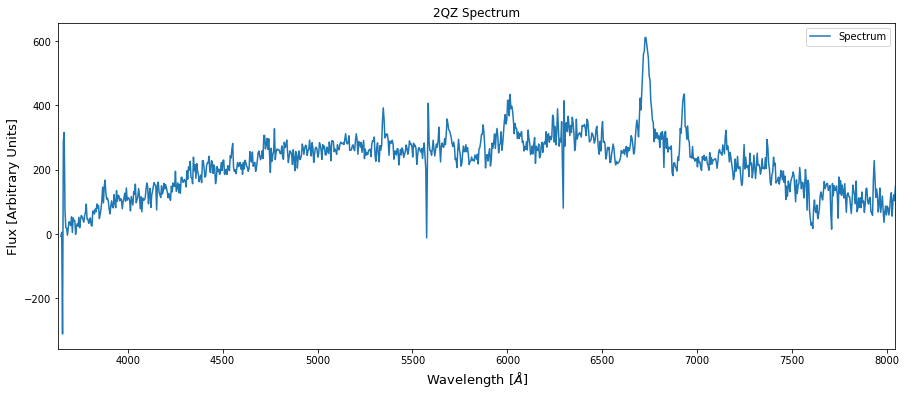

In [47]:
plt.figure(figsize=(15, 6))

plt.plot(wv_qz, qz_fits.data, label='Spectrum')
#plt.plot(wv_qz, qz_var.data, label='Variance')

#plt.axhline(0, color='k')

plt.legend()

plt.xlim(qz_fits.header['WMIN'], qz_fits.header['WMAX'])
#plt.ylim(-20, 400)

plt.title('2QZ Spectrum')
plt.xlabel(r'Wavelength [$\AA$]', size=13)
plt.ylabel('Flux [Arbitrary Units]', size=13)

## Getting photometry from spectra

The goal of this project is to make realistic mock galaxy catalogs of photometry, not spectra.
Photometry refers to an extremely coarse spectrum whose pixels are the flux through a handful of broadband filters.
We're starting from spectra rather than another photometric dataset because we would in general want to make a mock catalog for a survey with different filters than the available real galaxy catalog.
However, we don't want to work with spectra because they're high dimensional, and we're going to downsample them to photometry for the final catalog anyway.
Therefore, we can turn our input spectra into photometry with the same filters as the target mock catalog.

*Caveat: This assumes that the photometric observations would have the same systematics of the optics, etc.
We'll have to discuss this in the paper. . .*

### Filter transmission curves

*TODO: Plot the transmission curves first.*

In [48]:
## this is mostly an SNCOSMO code that I updated to be able to return spectra
from sncosmo_spectrum import Spectrum as sncosmo_Spec ## My error code is not working
# This will give you photometry but not the error on photometry right now
#import sncosmo

def photometry(wavelength, spectrum, variance, band, magnitudes=True, magsystem='ab', **kwargs):
    '''
        band: Check sncosmo for list of bands
        magsystem: Check sncosmo for list of magsystems
    '''
    # Define a spectrum object
    #spectrum = sncosmo.Spectrum(wavelength, spectrum)
    spectrum = sncosmo_Spec(wavelength, spectrum, error=variance)

    ## Something to add new filters
    ### build into SNCosmo: Bessel, SNLS, DES, SDSS, HST ACS WFC, WFC3 IR,
    ### WFC2 UVIS, Kepler, CSP, JWST NIRCAM/MIRI (nah), LSST, keplercam, 4shooter
    ### This actually may need to be built somewhere else

    # Calculate flux and flux error in specific band
    flux, fluxerr = spectrum.bandflux(band)

    # MagSystem
    mag = sncosmo.get_magsystem(magsystem)
    
    # Calculate magnitudes and mag errors from flux
    magn = mag.band_flux_to_mag(flux, band)
    magerr = 2.5/np.log(10) / flux * fluxerr 
    #2.5/np.log(10) / bsnf2[0] * bsnf2[1]

    if magnitudes:
        return magn, magerr
    else:
        return flux , fluxerr

In [49]:
## This cell creates an array of zeros of size (N spectra, M bandpasses).
# Here we can set some limits if we want so that we don't open everything, but we can choose to do this later
# right now it opens everything but I included the df keywords for probability the redshift is right ('PROB') and 
# the 'NQ' which should be larger than 2 based off the GAMA header
# once everything is read in, I clean the data of NANs and then generate the photometry.

header_keyword_dict = {'GAMA': 'CD1_1', 'SDSS': 'CDELT1', 'VVDS': 'CDELT1'}
bandpasses = ['lsstg', 'lsstr', 'lssti']

phot_measures = np.zeros((len(df[0:20]), len(bandpasses), 2))

for n, expand in enumerate(df[0:20].iterrows()):
    index, row = expand
    if row['PROB'] > -0.68 and row['NQ'] > 2:
        s = row['SURVEY'].decode('utf-8').strip()
        if s in ['GAMA', 'SDSS', 'VVDS']:
            
            f = row['FILENAME'].decode('utf-8')[1:].strip()
            hdu = fits.open(f)
            spectrum = hdu[0].data[0]
            error = hdu[0].data[1]
            header_info = hdu[0].header
            
            x = np.arange(0, len(spectrum))
            if s in 'SDSS':
                wv_log = header_info['CRVAL1'] + header_info[header_keyword_dict[s]] * x
                wv = 10**(wv_log)
            else:
                wv = header_info['WMIN'] + header_info[header_keyword_dict[s]] * x
                        
            if s in 'VVDS':
                spectrum = spectrum/1e-17
                error = error/1e-17

            # Now I need to clean out the nans from the flux.
            nonan_flux = np.array([x for x in spectrum if not np.isnan(x)])
            
            nonan_wv = []
            nonan_err = []
            for w, f, e in zip(wv, spectrum, error):
                if ~np.isnan(f):
                    nonan_wv.append(w)
                    nonan_err.append(e)
            nonan_wv = np.array(nonan_wv)
            nonan_err = np.array(nonan_err)

            for i, b in enumerate(bandpasses):
                try:
                    mag, mag_err = photometry(nonan_wv, nonan_flux*1e-17, nonan_err*1e-17, b)
                    phot_measures[n, i, 0] = mag
                    phot_measures[n, i, 1] = mag_err
                except:
                    continue

            hdu.close()


/home/aimalz/Code/COIN/recidivator/GAMA/sncosmo_spectrum.py:78: UserWarning: error keyword in Spectrum is deprecated in sncosmo 1.4 and will be removed in sncosmo 2.0
  warn_once("error keyword in Spectrum", "1.4", "2.0")


In [50]:
## You'll see here a bad pixel in spectrum for iloc=17 causing the g-band to fail to produce photometry
phot_measures[0]

array([[1.94407610e+01, 1.24653318e-02],
       [1.85951948e+01, 6.36069598e-03],
       [1.79218211e+01, 5.43916078e-03]])

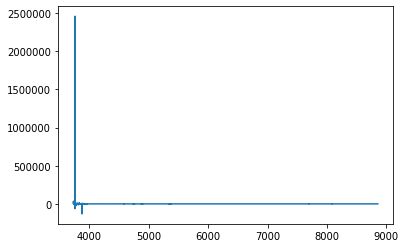

In [62]:
hdu = fits.open(df.iloc[17]['FILENAME'].decode('utf-8')[1:].strip())
spectrum = hdu[0].data[0]
header_info = hdu[0].header
x = np.arange(0, len(spectrum))
wv = header_info['WMIN'] + header_info['CD1_1'] * x
plt.plot(wv, spectrum)
# plt.semilogy()

In [52]:
## In order to add these to the data frame, 
#I do a deep copy of only the files I downloaded and then added the columns. 
df20 = df.copy()[0:20]

In [53]:
band_err = ['lsstg_err', 'lsstr_err', 'lssti_err']
for i, b in enumerate(zip(bandpasses, band_err)):
    bp, bp_err = b
    df20[bp] = phot_measures[:, i, 0]
    df20[bp_err] = phot_measures[:, i, 1]

In [54]:
df20

,CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA,...,PROB,FILENAME,URL,URL_IMG,lsstg,lsstg_err,lsstr,lsstr_err,lssti,lssti_err
CATAID,,,,,,,,,,,,,,,,,,,,,
6802,6802,b'GAMAJ113601.43+004315.3',4104,1,1,0.07,b'G12_Y3_017_187 ',b'GAMA ',5,174.00600,...,1.000,b'/GAMA/dr3/data/spectra/gama/reduced_27/1d/G1...,b'http://www.gama-survey.org/dr3/data/spectra/...,b'http://www.gama-survey.org/dr3/data/spectra/...,19.440761,0.012465,18.595195,0.006361,17.921821,0.005439
6806,6806,b'GAMAJ113605.47+004221.3',4104,1,1,0.07,b'G12_Y1_AN1_238 ',b'GAMA ',5,174.02279,...,1.000,b'/GAMA/dr3/data/spectra/gama/reduced_27/1d/G1...,b'http://www.gama-survey.org/dr3/data/spectra/...,b'http://www.gama-survey.org/dr3/data/spectra/...,19.337343,0.010736,18.565726,0.003934,18.277036,0.003315
6808,6808,b'GAMAJ113624.17+003932.1',4104,1,1,0.08,b'G12_Y1_AN1_235 ',b'GAMA ',5,174.10071,...,1.000,b'/GAMA/dr3/data/spectra/gama/reduced_27/1d/G1...,b'http://www.gama-survey.org/dr3/data/spectra/...,b'http://www.gama-survey.org/dr3/data/spectra/...,19.699144,0.010966,18.823397,0.004000,18.513115,0.003209
6810,6810,b'GAMAJ113626.18+004814.0',4104,1,1,0.05,b'G12_Y2_041_164 ',b'GAMA ',5,174.10908,...,1.000,b'/GAMA/dr3/data/spectra/gama/reduced_27/1d/G1...,b'http://www.gama-survey.org/dr3/data/spectra/...,b'http://www.gama-survey.org/dr3/data/spectra/...,19.943401,0.011138,19.134175,0.004368,18.731505,0.004834
6813,6813,b'GAMAJ113615.31+003840.3',4104,1,1,0.05,b'G12_Y3_017_177 ',b'GAMA ',5,174.06383,...,1.000,b'/GAMA/dr3/data/spectra/gama/reduced_27/1d/G1...,b'http://www.gama-survey.org/dr3/data/spectra/...,b'http://www.gama-survey.org/dr3/data/spectra/...,20.402537,0.021644,19.208827,0.009793,18.452257,0.008246
6816,6816,b'GAMAJ113604.55+003956.8',4104,1,1,0.04,b'G12_Y3_017_182 ',b'GAMA ',5,174.01896,...,0.986,b'/GAMA/dr3/data/spectra/gama/reduced_27/1d/G1...,b'http://www.gama-survey.org/dr3/data/spectra/...,b'http://www.gama-survey.org/dr3/data/spectra/...,20.989969,0.062058,19.750194,0.023459,18.841872,0.015093
6820,6820,b'GAMAJ113608.43+004721.4',4104,3,3,0.05,b'G12_Y3_033_174 ',b'GAMA ',5,174.03512,...,0.999,b'/GAMA/dr3/data/spectra/gama/reduced_27/1d/G1...,b'http://www.gama-survey.org/dr3/data/spectra/...,b'http://www.gama-survey.org/dr3/data/spectra/...,20.301303,0.030183,19.589273,0.018765,19.023542,0.014662
6821,6821,b'GAMAJ113636.75+004855.5',4104,1,1,0.11,b'G12_Y1_AN1_254 ',b'GAMA ',5,174.15312,...,0.998,b'/GAMA/dr3/data/spectra/gama/reduced_27/1d/G1...,b'http://www.gama-survey.org/dr3/data/spectra/...,b'http://www.gama-survey.org/dr3/data/spectra/...,14.045135,0.001225,14.703766,0.001172,15.314228,0.001769
6826,6826,b'GAMAJ113644.38+004232.5',4104,3,0,0.01,b'317651685860206592 ',b'SDSS ',1,174.18493,...,0.000,b'/GAMA/dr3/data/spectra/sdss/spec-0282-51658-...,b'http://www.gama-survey.org/dr3/data/spectra/...,b'http://www.gama-survey.org/dr3/data/spectra/...,18.680231,0.003856,18.210349,0.007387,17.838547,0.001636


## Relationship between redshift and photometry

Text(0.5, 0, 'redshift')

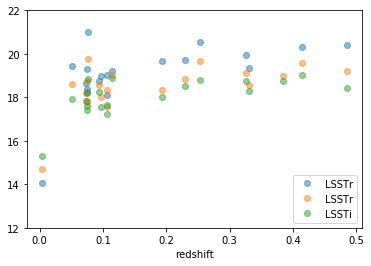

In [94]:
# plt.plot(df20['Z'], df20['lsstg'], 'o', alpha=0.5, label='LSSTr')
# plt.plot(df20['Z'], df20['lsstr'], 'o', alpha=0.5, label='LSSTr')
# plt.plot(df20['Z'], df20['lssti'], 'o', alpha=0.5, label='LSSTi')

# plt.ylim(12, 22)
# plt.legend()
# plt.xlabel('redshift')

In [89]:
def mycorner(datum, keys, color_by, lims=None):#, filename='plot.pdf'):
    ncol = len(keys)
    fig = plt.figure(figsize=(ncol*5, ncol*5))
    ax = [[fig.add_subplot(ncol, ncol, ncol * i + j + 1) for j in range(i+1)] for i in range(ncol)]
    for i in range(ncol):
        for j in range(i+1):
            if i == j:
                ax[i][j].hist(datum[keys[i]], bins=50, histtype='step', linewidth=2, density=True, alpha=0.75, color='k')
                ax[i][j].set_xlabel(keys[i])
                ax[i][j].set_xlim(lims[keys[i]])
            else:
                ax[i][j].scatter(datum[keys[i]], datum[keys[j]], c=datum[color_by])
                ax[i][j].set_xlabel(keys[i])
                ax[i][j].set_ylabel(keys[j])
                if lims is not None:
                    ax[i][j].set_xlim(lims[keys[i]])
                    ax[i][j].set_ylim(lims[keys[j]])
#     fig.savefig(filename, dpi=100)
    return

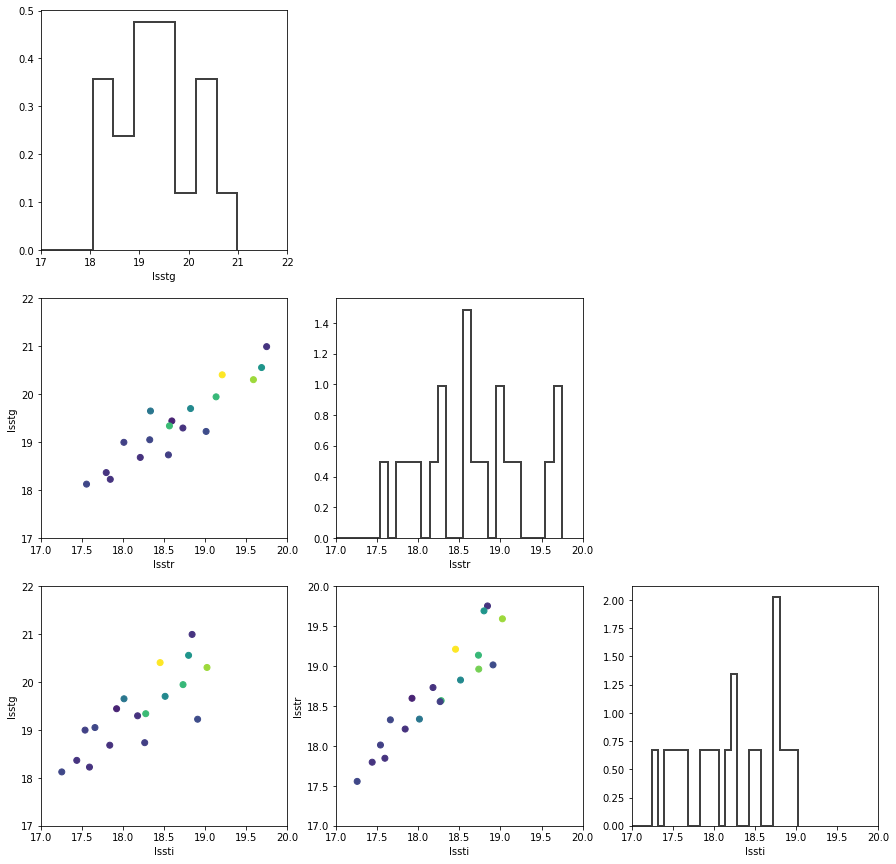

In [91]:
lims = {'lsstg': (17., 22.), 'lsstr': (17., 20.), 'lssti': (17., 20.)}

mycorner(df20, bandpasses, 'Z', lims=lims)

Text(0, 0.5, 'r-i')

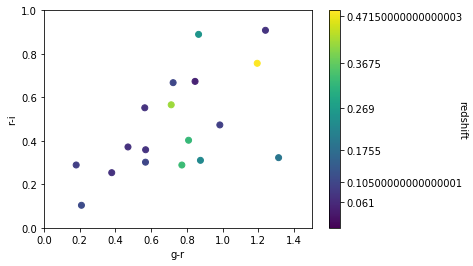

In [107]:
## Color plot

# plt.plot(df20['Z'], df20['lsstg']- df20['lsstr'], 'o', alpha=0.5, label='g-r')
# plt.plot(df20['Z'], df20['lsstr']- df20['lssti'], 'o', alpha=0.5, label='r-i')
# plt.ylim(-1., 2)
fig, ax = plt.subplots()
cax = plt.scatter(df20['lsstg']- df20['lsstr'], df20['lsstr']- df20['lssti'], c=df20['Z']/max(df20['Z']))
plt.xlim(0., 1.5)
plt.ylim(0., 1.)
cbar = fig.colorbar(cax, ticks=z_bins/max(df20['Z']))
cbar.ax.set_yticklabels(z_bins)
cbar.set_label('redshift', rotation=270)
# plt.legend()
plt.xlabel('g-r')
plt.ylabel('r-i')

Over a larger redshift range, this latter plot usually lo

# Next steps


## choose and implement a measure of "environment"

## construct redshift-environment-SED/color relationship

## TBD Question: Is the flux given the restframe? Most likely but I should double check just in case